In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
n_classes = 2
img_size = (224, 224)
batch_size = 16

train_dir = "/content/drive/MyDrive/freshness-food-datasets/train_set"
val_dir   = "/content/drive/MyDrive/freshness-food-datasets/val_set"

# Augmentasi ringan (warna, flip, zoom) karena freshness banyak dipengaruhi visual
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

print("Class indices:", train_generator.class_indices)

Found 1450 images belonging to 2 classes.
Found 152 images belonging to 1 classes.
Class indices: {'fresh-foods': 0, 'rotten-foods': 1}


In [4]:
base_model = tf.keras.applications.DenseNet201(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)   # cukup 256 neuron
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze backbone dulu (fine-tune belakangan)
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,814,017 (71.77 MB)

 Trainable params: 492,033 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [5]:
checkpoint = ModelCheckpoint(
    filepath="freshness_best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8982 - loss: 0.2707
Epoch 1: val_accuracy improved from 0.70395 to 0.88158, saving model to freshness_best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.8982 - loss: 0.2707 - val_accuracy: 0.8816 - val_loss: 0.3171 - learning_rate: 5.0000e-05
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9174 - loss: 0.2344
Epoch 2: val_accuracy improved from 0.88158 to 0.88816, saving model to freshness_best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.9174 - loss: 0.2343 - val_accuracy: 0.8882 - val_loss: 0.2998 - learning_rate: 5.0000e-05
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9152 - loss: 0.2174
Epoch 3: val_accuracy improved from 0.88816 to 0.90789, saving model to freshness_best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.9153 - loss: 0.2172 - val_accuracy: 0.9079 - val_loss: 0.2603 - learning_rate: 5.0000e-05
Epoch 4/30
91/91 ━━━━━

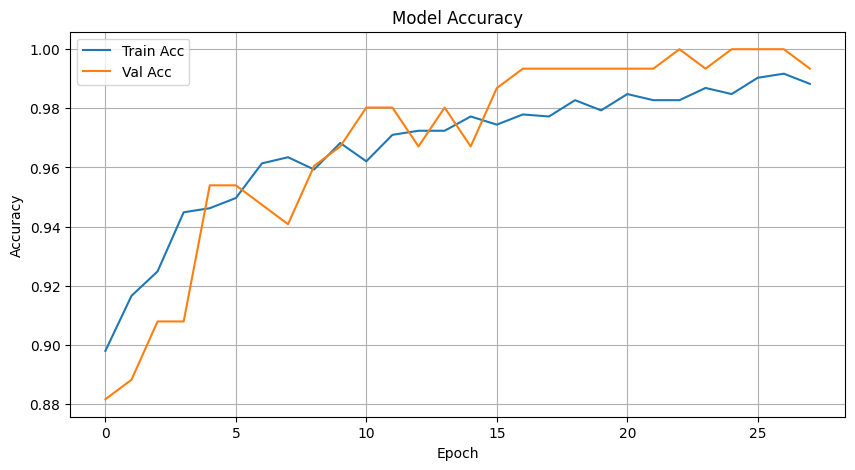

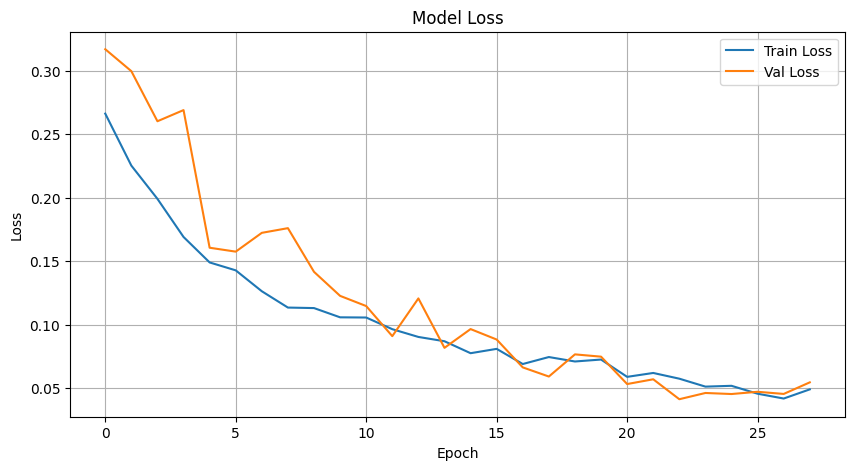

In [8]:
# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_indices = train_generator.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}

def predict_freshness(img_path):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    idx = np.argmax(preds, axis=1)[0]
    return idx_to_class[idx], float(np.max(preds))

# Contoh prediksi
label, conf = predict_freshness("/content/test_food.jpg")
print(f"Prediksi: {label} (conf={conf:.2f})")

FileNotFoundError: [Errno 2] No such file or directory: '/content/test_food.jpg'